# Line Detection for indoor hallways
By: Alejandro Daniel José Gómez Flórez

## Objetive:
- Create a pipeline to process the image captured by the car and detect the lines in the hallway.
- Detect the lines that delimit the wall from the floor.

## Environment
![](space.jpeg)

## Car used for navigation
The purpose of this project is to detect lanes in a indoor hallway to provide information for a scaled car the borders for its navigation.

![car](car.jpeg)

## Camera in the Car
The camera chossen and used in the car to capture the images is the C920 Camera, wich provides a 1080*720 pixels.
![c920](C920Camera.jpeg)

Although the camera provides a high resolution in 1080*720 pixels, inside the car, the image was chosen as 240*320 pixels to reduce the number of pixels to be processed. The final purpose is to reduce the processing time to allows use inside of a real-time application, that provides to the car take decisions from images captured.

## Dataset
The dataset used for this project was taken from the car going through the hallway in remote control mode. The images were taken with a sample time of 500 ms. The complete dataset is available in the folder [dataSet3](./dataSet3)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

(240, 320, 3)


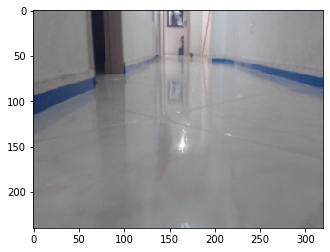

In [2]:
# img_lane = cv2.imread('dataSet3/image_1628786138240.jpg')
img_lane = cv2.imread('dataSet3/image_1628786135241.jpg')
plt.imshow(cv2.cvtColor(img_lane, cv2.COLOR_BGR2RGB))
print(img_lane.shape)

In [3]:
# change variable name to indicates that it is to save result images
lane_base_file_name = 'results/03_lane_lines_'

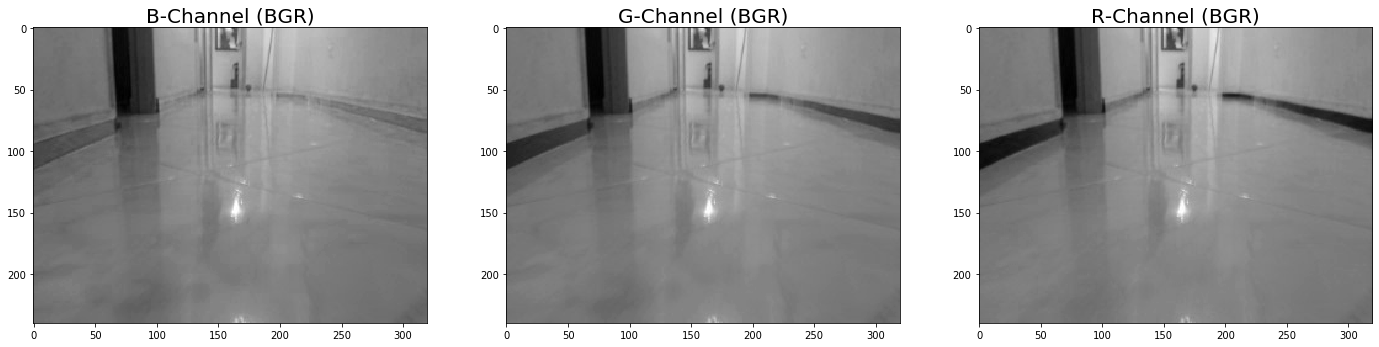

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

ax1.set_title('B-Channel (BGR)', fontsize=20)
ax2.set_title('G-Channel (BGR)', fontsize=20)
ax3.set_title('R-Channel (BGR)', fontsize=20)

ax1.imshow(img_lane[:,:,0], cmap='gray')
ax2.imshow(img_lane[:,:,1], cmap='gray')
ax3.imshow(img_lane[:,:,2], cmap='gray')

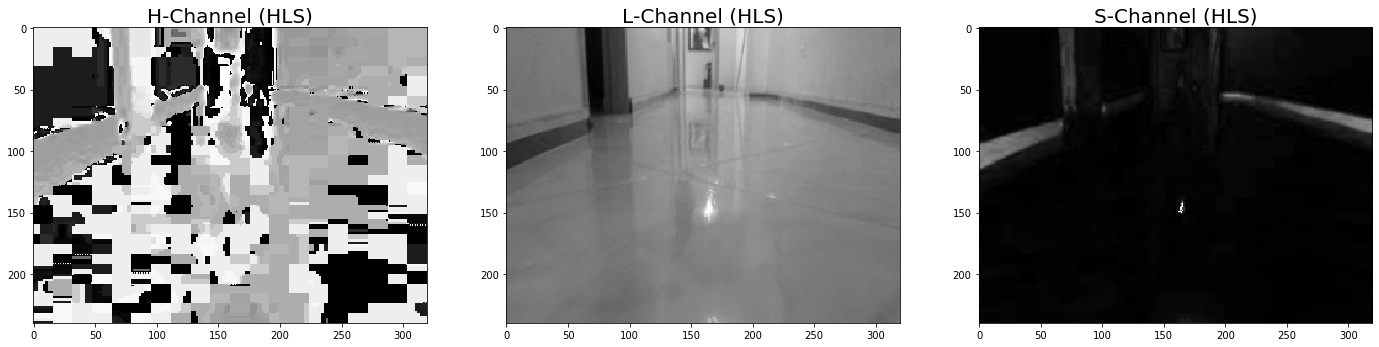

In [5]:
hls_img_lane = cv2.cvtColor(img_lane, cv2.COLOR_BGR2HLS)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

ax1.set_title('H-Channel (HLS)', fontsize=20)
ax2.set_title('L-Channel (HLS)', fontsize=20)
ax3.set_title('S-Channel (HLS)', fontsize=20)

ax1.imshow(hls_img_lane[:,:,0], cmap='gray')
ax2.imshow(hls_img_lane[:,:,1], cmap='gray')
ax3.imshow(hls_img_lane[:,:,2], cmap='gray')

f.savefig('results/hls.png', bbox_inches='tight')

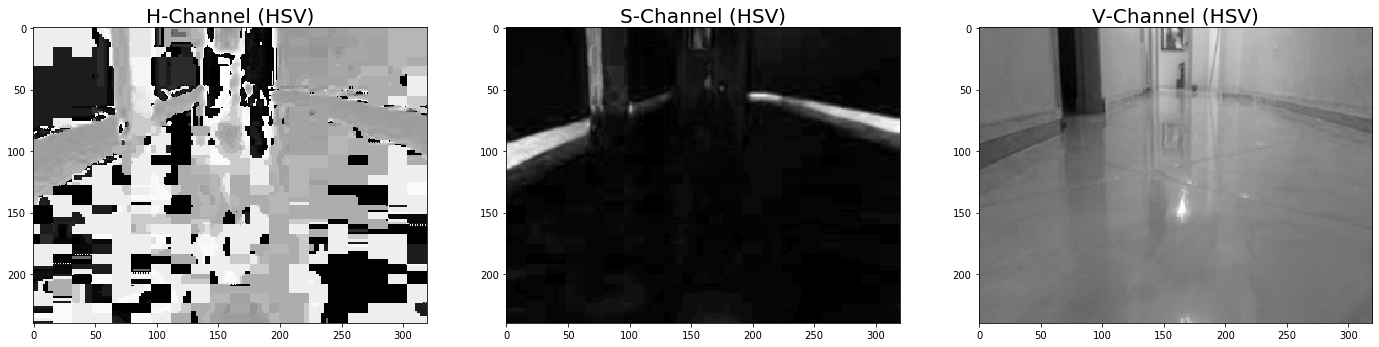

In [6]:
hsv_img_lane = cv2.cvtColor(img_lane, cv2.COLOR_BGR2HSV)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

ax1.set_title('H-Channel (HSV)', fontsize=20)
ax2.set_title('S-Channel (HSV)', fontsize=20)
ax3.set_title('V-Channel (HSV)', fontsize=20)

ax1.imshow(hsv_img_lane[:,:,0], cmap='gray')
ax2.imshow(hsv_img_lane[:,:,1], cmap='gray')
ax3.imshow(hsv_img_lane[:,:,2], cmap='gray')

f.savefig('results/hsv.png', bbox_inches='tight')

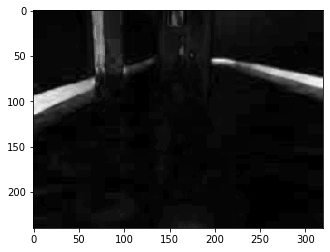

In [7]:
selected_channel = hsv_img_lane[:,:,1]
plt.imshow(selected_channel, cmap='gray')

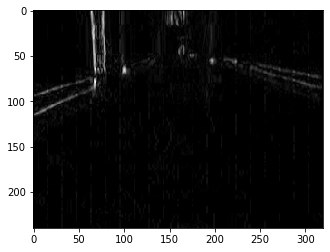

In [8]:
def sobel_x(img):
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel

gray = selected_channel
scaled_sobel = sobel_x(gray)
plt.imshow(scaled_sobel, cmap='gray')
plt.imsave('results/04_sobel_x.jpg', scaled_sobel, cmap='gray')

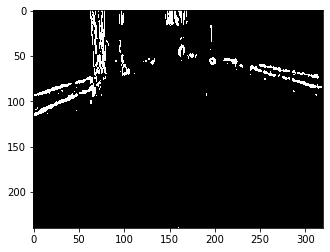

In [9]:
def sobel_x_binary(img, thresh_min, thresh_max):
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

sxbinary = sobel_x_binary(gray, 30, 150)
plt.imshow(sxbinary, cmap='gray')
plt.imsave('results/04_sobel_binary_x.jpg', sxbinary, cmap='gray')

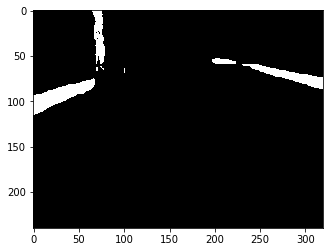

In [10]:
def binary(img, thresh_min, thresh_max):
    binary = np.zeros_like(img)
    binary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return binary

b_image = binary(selected_channel, 80, 255)
plt.imshow(b_image, cmap='gray')
plt.imsave('results/04_binary_threshold.jpg', b_image, cmap='gray')

In [11]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_region(img, vertices):
    line_color = (255, 0, 0)
    thickness = 3
    
    image = np.copy(img)
    
    image = cv2.line(image, vertices[0], vertices[1], line_color, thickness)
    image = cv2.line(image, vertices[1], vertices[2], line_color, thickness)
    image = cv2.line(image, vertices[2], vertices[3], line_color, thickness)
    image = cv2.line(image, vertices[3], vertices[0], line_color, thickness)
    return image

In [12]:
img_lane.shape

(240, 320, 3)

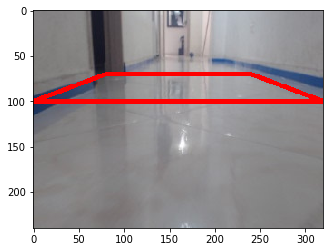

In [13]:
## Region of interest
(height, width) = img_lane.shape[:2]
mid_offset = 80
bottom_offset = 0
x_offset = 0
y_bottom_offset = 140
y_top_offset = 50

mid_y = height // 2
mid_width = width // 2

left_bottom = (0 + bottom_offset + x_offset, height - y_bottom_offset)
right_bottom = (width - bottom_offset + x_offset, height - y_bottom_offset)
apex1 = ( mid_width - mid_offset + x_offset, mid_y - y_top_offset)
apex2 = ( mid_width + mid_offset + x_offset, mid_y - y_top_offset)
corners = [left_bottom, right_bottom, apex2, apex1]

rgb_lane_lines = cv2.cvtColor(img_lane, cv2.COLOR_BGR2RGB)
img_region_lines = draw_region(rgb_lane_lines, corners)
plt.imshow(img_region_lines)
plt.imsave('results/05_lines_perspective.jpg', img_region_lines)

In [14]:
def bird_view(img, corners_list):
    offset = 100 # offset for dst points
    img_size = (img.shape[1], img.shape[0])

    src_points = np.float32(corners_list)
    
    dst_points = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                 [img_size[0]-offset, img_size[1]], 
                                 [offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, M_inv

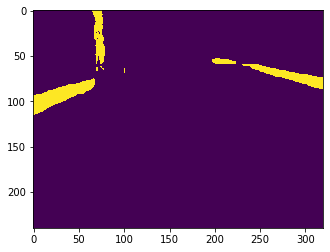

In [15]:
plt.imshow(b_image)

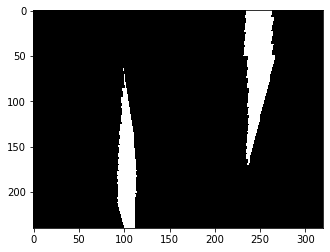

In [16]:
bird_view, M, M_inv = bird_view(b_image, corners[::-1])
plt.imshow(bird_view, cmap='gray')

plt.imsave('results/05_bird_view.jpg', bird_view, cmap='gray')

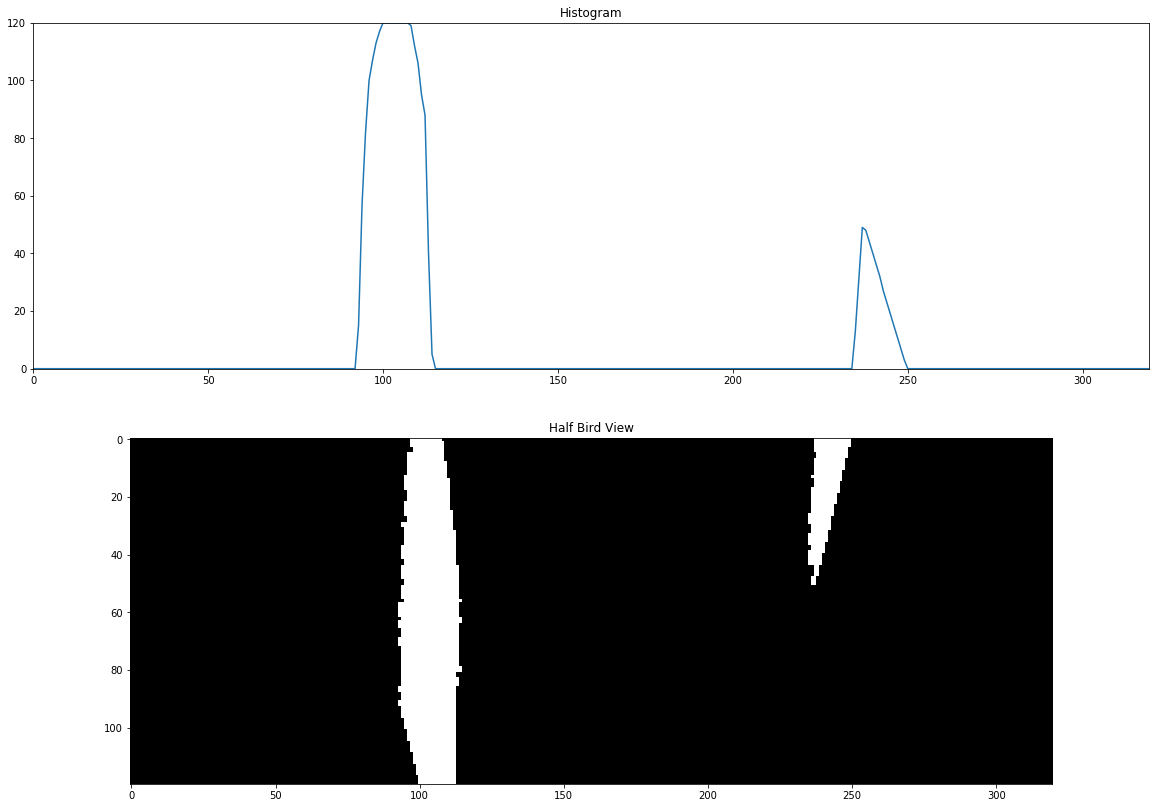

In [17]:
def _lr_peaks_histogram(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram, bottom_half

histogram, bottom_half = _lr_peaks_histogram(bird_view)

f = plt.figure(figsize=(20,14))
f.tight_layout()
ax1 = f.add_subplot(2,1,1)
ax1.set_title('Histogram')

ax1.margins(0)
ax1.plot(histogram)

ax2 = f.add_subplot(2,1,2)
ax2.set_title('Half Bird View')
ax2.imshow(bottom_half, cmap='gray')
 
f.savefig('results/06_histogram.png', bbox_inches='tight')

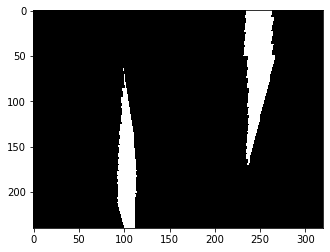

In [18]:
img_bin = bird_view
plt.imshow(img_bin, cmap='gray')

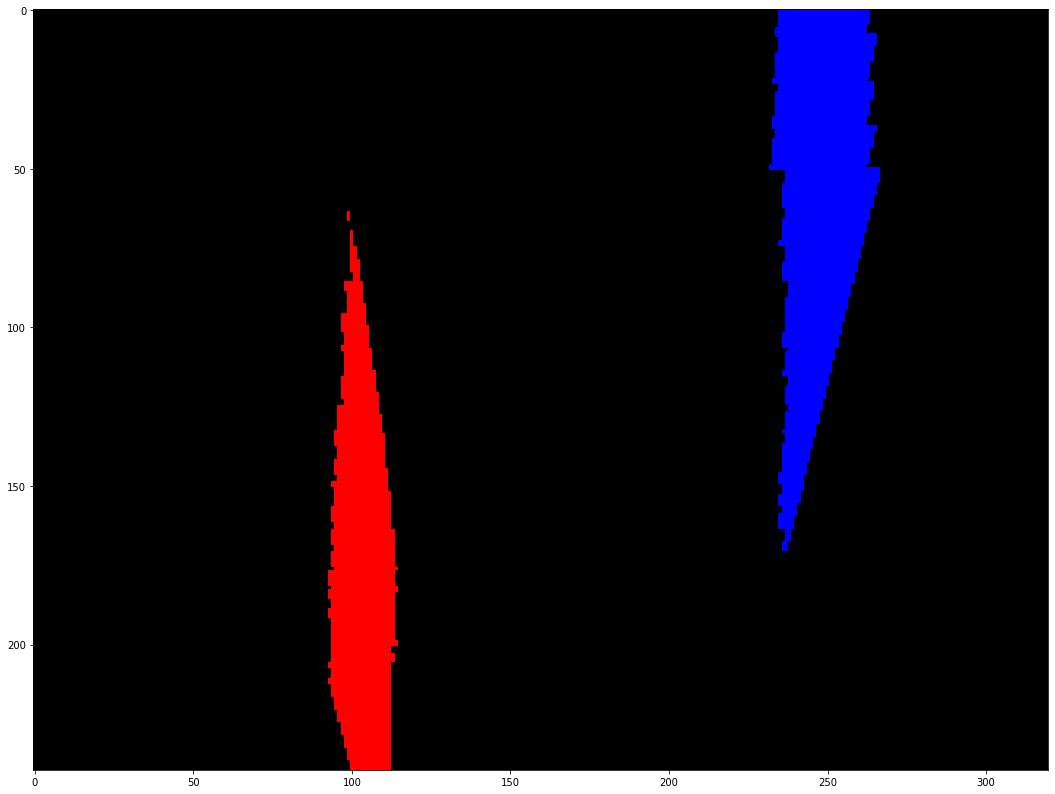

In [19]:
plt.figure(figsize=(20,14))
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 4
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 4) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 4)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img

# leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
out_img = fit_polynomial(img_bin)

plt.imshow(out_img)
plt.savefig('results/07_slidding_window.png', bbox_inches='tight')

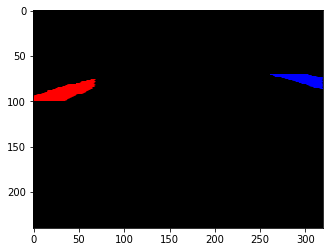

In [20]:
img_inv = cv2.warpPerspective(out_img, M_inv, (width, height)) # Inverse transformation
plt.imshow(img_inv, cmap='gray')

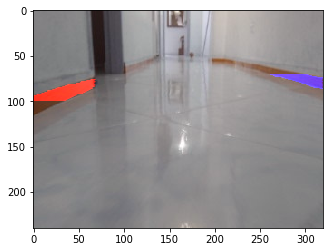

In [21]:
result = cv2.addWeighted(img_inv, 0.8, img_lane, 1, 0)
plt.imshow(result)